# Description

Film Junky Union, a new community for classic film enthusiasts, is in the process of developing a system to filter and categorize movie reviews. Its main mission is to train a model that can automatically detect negative reviews. You will use the IMDb movie review dataset with polarity labeling to create a model capable of classifying reviews as positive and negative. This model should achieve an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# The next line provides a higher-quality graph on the HiDPI screen

# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# This is to use `progress_apply`. Read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Import Dataset

In [4]:
try:
    df_reviews = pd.read_csv('D:/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except:
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

There are two missing values in the data. However, we will not fill or remove them because the data we will be testing is in the "review" and "pos" columns. Also, because the small number of missing data points will not significantly affect the analysis results.

## EDA

Check the number of films and reviews over several years.

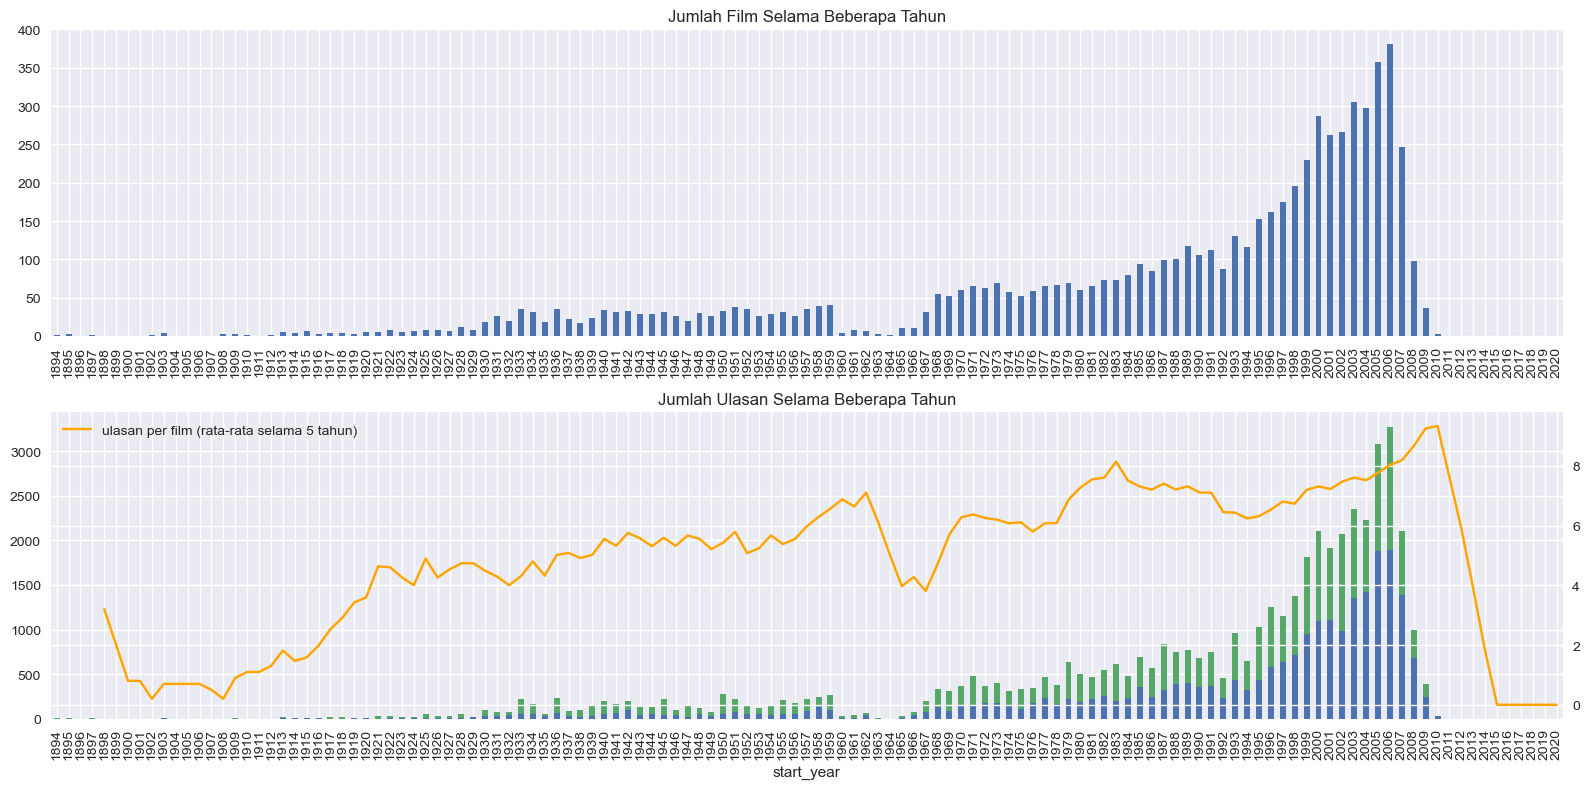

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Jumlah Film Selama Beberapa Tahun')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#ulasan  (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='ulasan per film (rata-rata selama 5 tahun)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Jumlah Ulasan Selama Beberapa Tahun') 

fig.tight_layout()

Examine the distribution of the number of reviews per film using precise counting and KDE (Kernel Density Estimation) to understand the differences from precise counting.

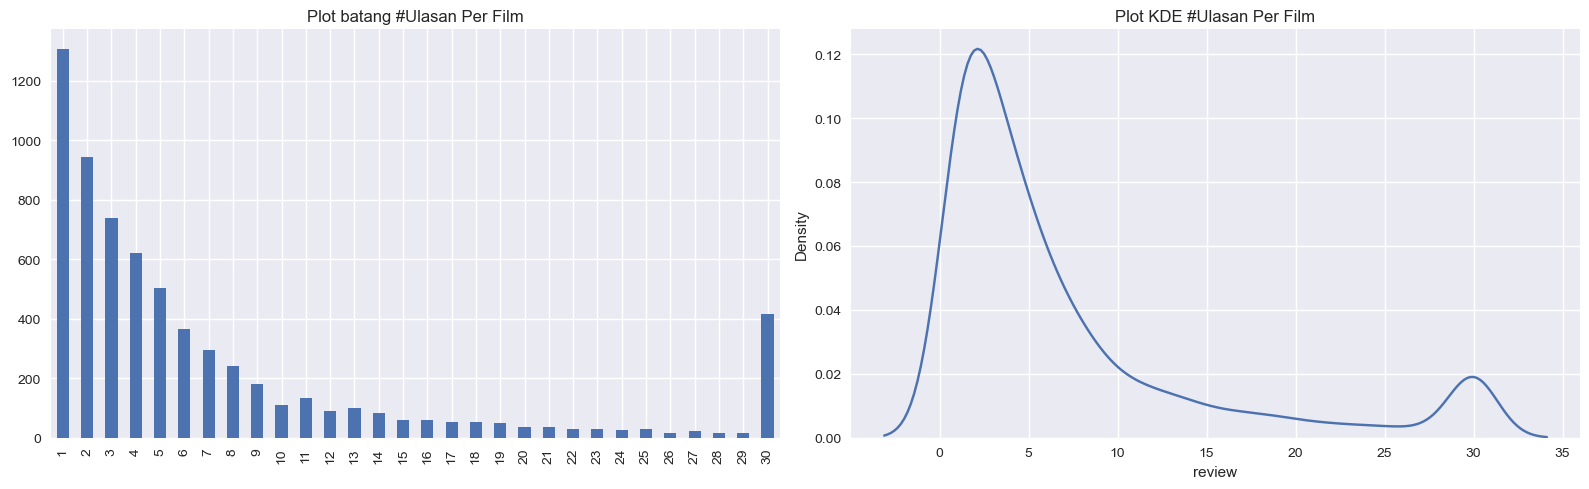

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Plot batang #Ulasan Per Film')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Plot KDE #Ulasan Per Film') 

fig.tight_layout()

In [9]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

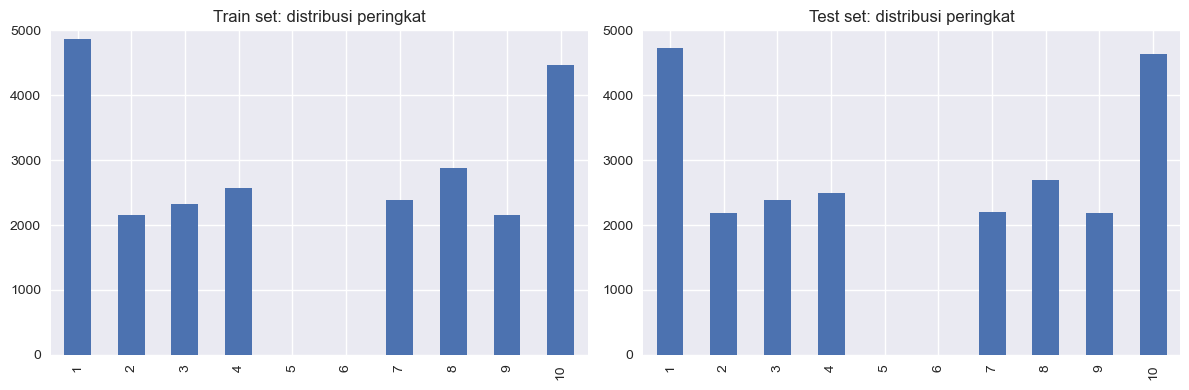

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: distribusi peringkat')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Test set: distribusi peringkat')

fig.tight_layout()

Examine the distribution of negative and positive reviews over the years for two parts of the dataset.

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


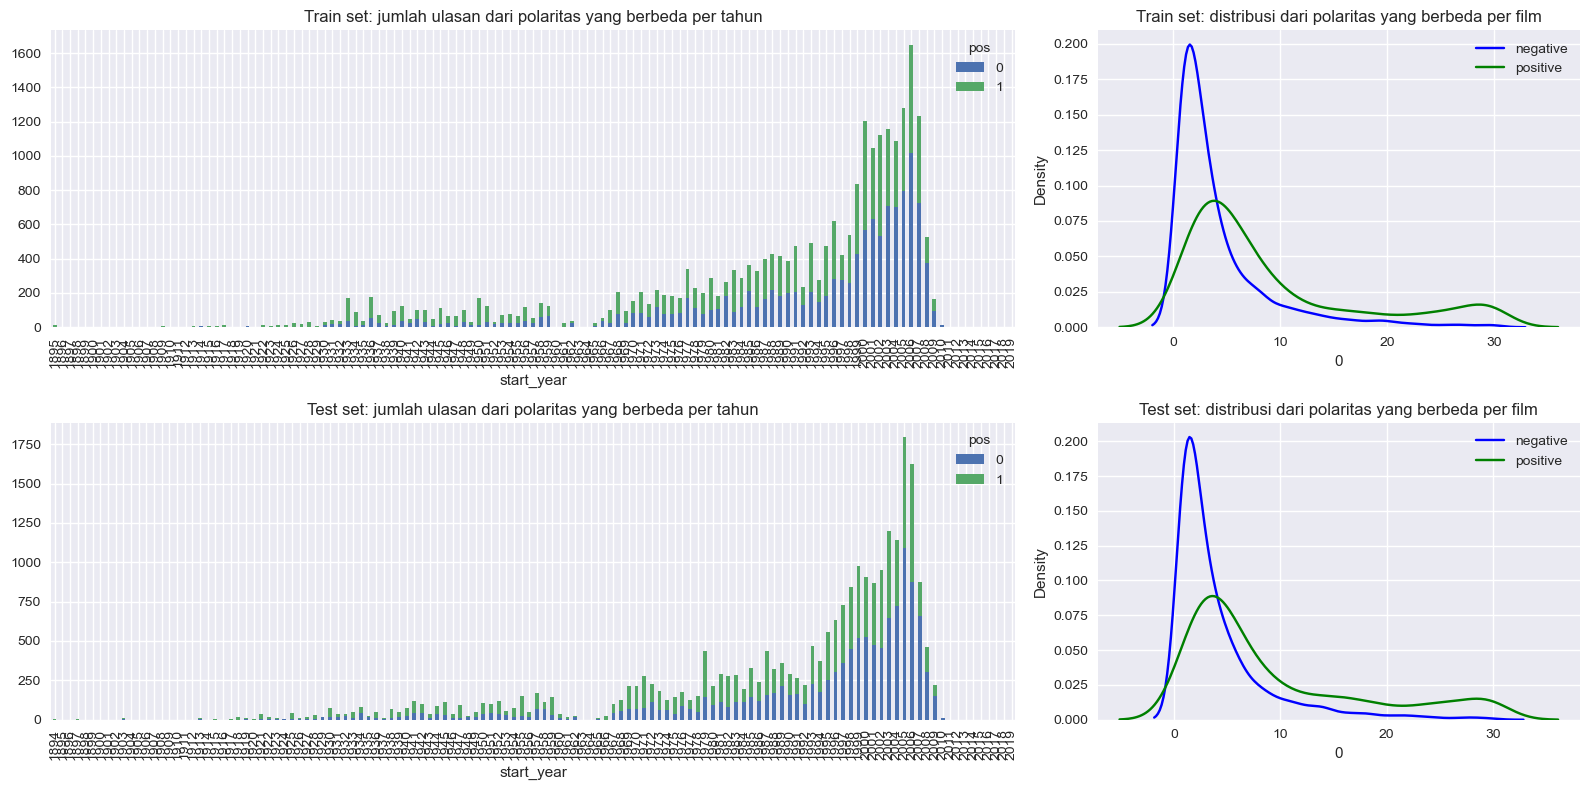

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Train set: jumlah ulasan dari polaritas yang berbeda per tahun')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Train set: distribusi dari polaritas yang berbeda per film')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Test set: jumlah ulasan dari polaritas yang berbeda per tahun')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Test set: distribusi dari polaritas yang berbeda per film')

fig.tight_layout()

## Evaluation Porcedure

Create an evaluation framework that can be consistently used for all models in this task.

In [12]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for tipe, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[tipe] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[tipe]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[tipe]['APS'] = aps
        
        if tipe == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Scor F1 
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{tipe}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # Set a threshold for several crossover points
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Skor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{tipe}, ROC AUC={roc_auc:.2f}')
        # Menetapkan ambang batas persilangan untuk beberapa titik
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Kurva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{tipe}, AP={aps:.2f}')
        # Set crossovers for multiple thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[tipe]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[tipe]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return 

## Normalization

We assume that all models below receive text in lowercase without numbers, punctuation, etc.

In [13]:
# normalization function
def normalize(text):
    pattern = r'[^a-zA-Z]'
    processed = re.sub(pattern, " ", text)
    processed = " ".join(processed.split())
    return processed.lower()

normalize_text = []
for i in range(len(df_reviews['review'])):
    normalize_text.append(normalize(df_reviews.loc[i]['review']))
    
df_reviews['review_norm'] = normalize_text

In [14]:
df_reviews['review_norm'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i m totally agree with garryjohal from singapo...
Name: review_norm, dtype: object

## Splitting Into Train and Test

Fortunately, the entire dataset has already been divided into train/test sets. The relevant flag is 'ds_part'.

In [15]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with The Model

### Model 0 - Constant

In [16]:
from sklearn.dummy import DummyClassifier

dummy_model = DummyClassifier(strategy='uniform', random_state=42)
dummy_model.fit(df_reviews_train, train_target)
dummy_model.predict(df_reviews_test)
dummy_model.score(df_reviews_train, train_target)

0.5068078668683812

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [17]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [18]:
import nltk
nltk.download('stopwords')

# create stopwords and create vectorizer
stop_words = set(stopwords.words('english'))
count_tf_idf1 = TfidfVectorizer(stop_words=list(stop_words))

# take corpus from data test and data train
corpus_train = df_reviews_train['review_norm']
corpus_test = df_reviews_test['review_norm']

# apply tf-idf on corpus
train_features_1 = count_tf_idf1.fit_transform(corpus_train)
test_features_1 = count_tf_idf1.transform(corpus_test)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


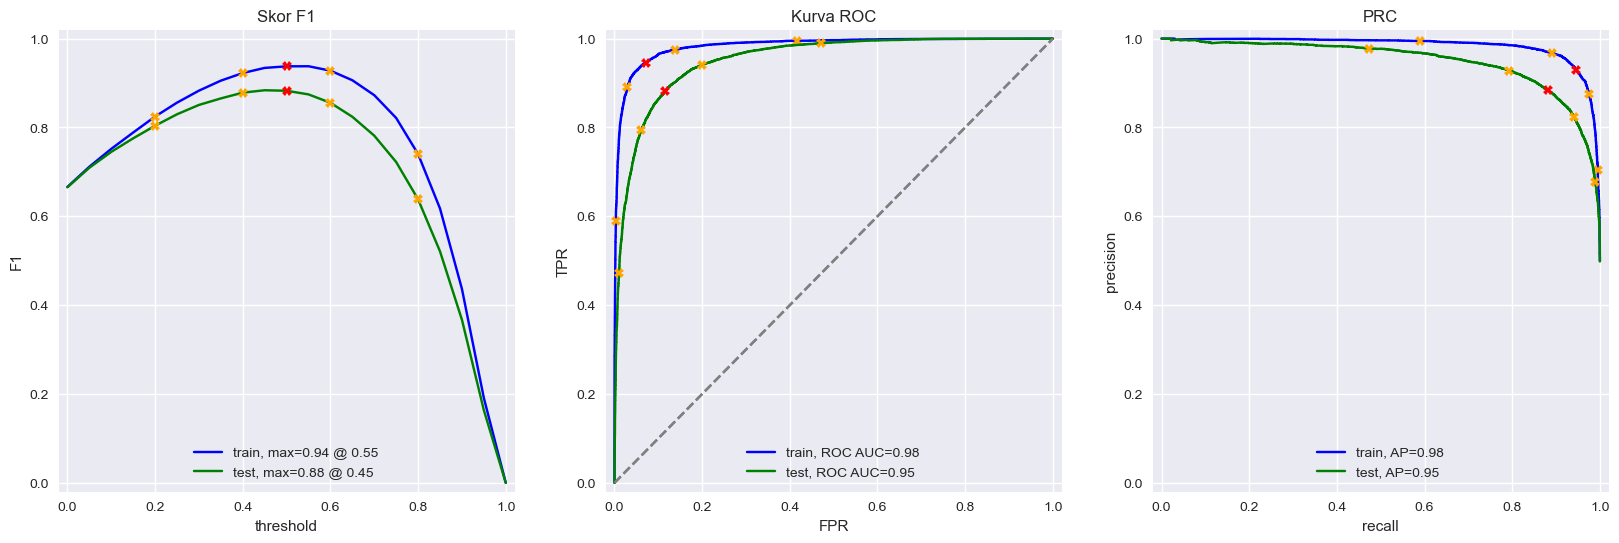

In [19]:
# model development
model_1 = LogisticRegression()
model_1.fit(train_features_1, train_target)
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 3 - spaCy, TF-IDF and LR

In [20]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [21]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


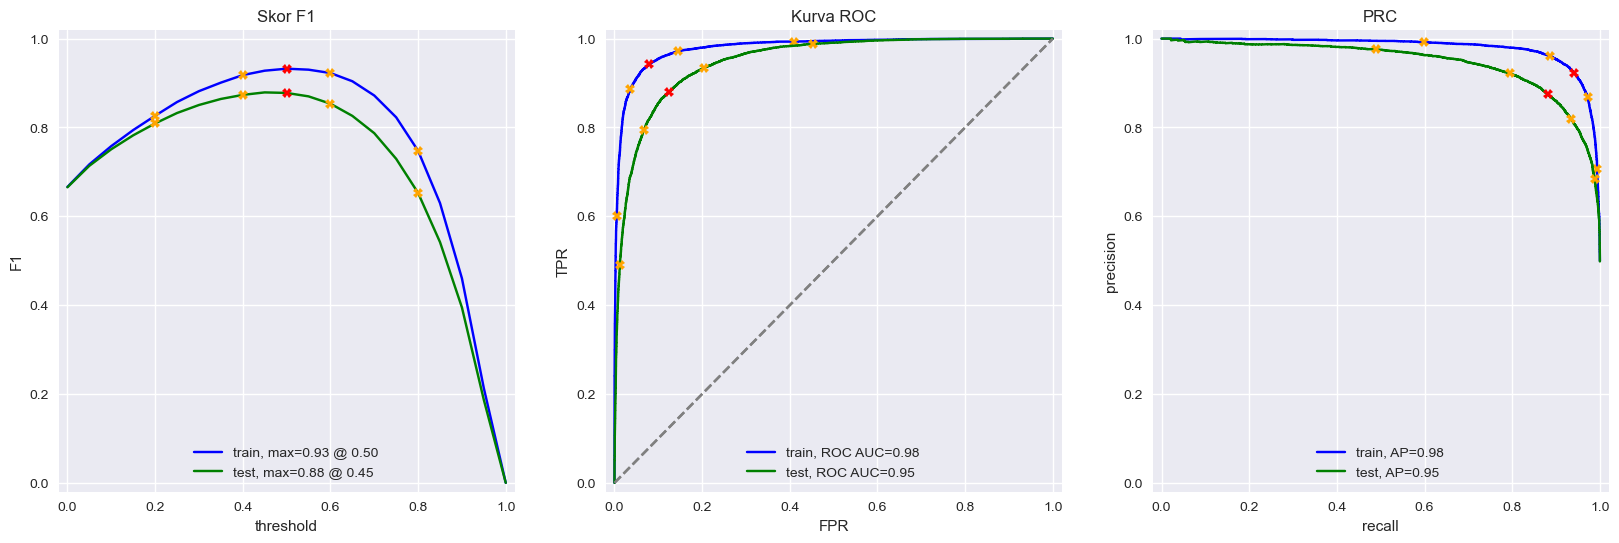

In [22]:
# apply tokenisasi spaCy on the data test and training
review_train = df_reviews_train['review_norm'].apply(text_preprocessing_3)
review_test = df_reviews_test['review_norm'].apply(text_preprocessing_3)

# apply tf-idf
count_tf_idf3 = TfidfVectorizer(stop_words=list(stop_words))
train_feature_3 = count_tf_idf3.fit_transform(review_train)
test_feature_3 = count_tf_idf3.transform(review_test)

# train the model
model_3 = LogisticRegression()
model_3.fit(train_feature_3, train_target)

# evaluate the model
evaluate_model(model_3, train_feature_3, train_target, test_feature_3, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [23]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

In [24]:
# hyperparameter tuning using GridSearcCV
model_4 = LGBMClassifier()
param_grid = {
    'num_leaves':[20, 100],
    'n_estimators':[50, 100],
    'learning_rate':[0.1, 0.5],
    'objective':['binary']
}
grid_cv = GridSearchCV(estimator=model_4, param_grid=param_grid, cv=5, n_jobs=-1)
grid_cv.fit(train_feature_3, train_target)
best_params = grid_cv.best_params_
print("Best Parameter:", best_params)

Best Parameter: {'learning_rate': 0.5, 'n_estimators': 100, 'num_leaves': 100, 'objective': 'binary'}


          train  test
Accuracy    1.0  0.86
F1          1.0  0.86
APS         1.0  0.94
ROC AUC     1.0  0.94


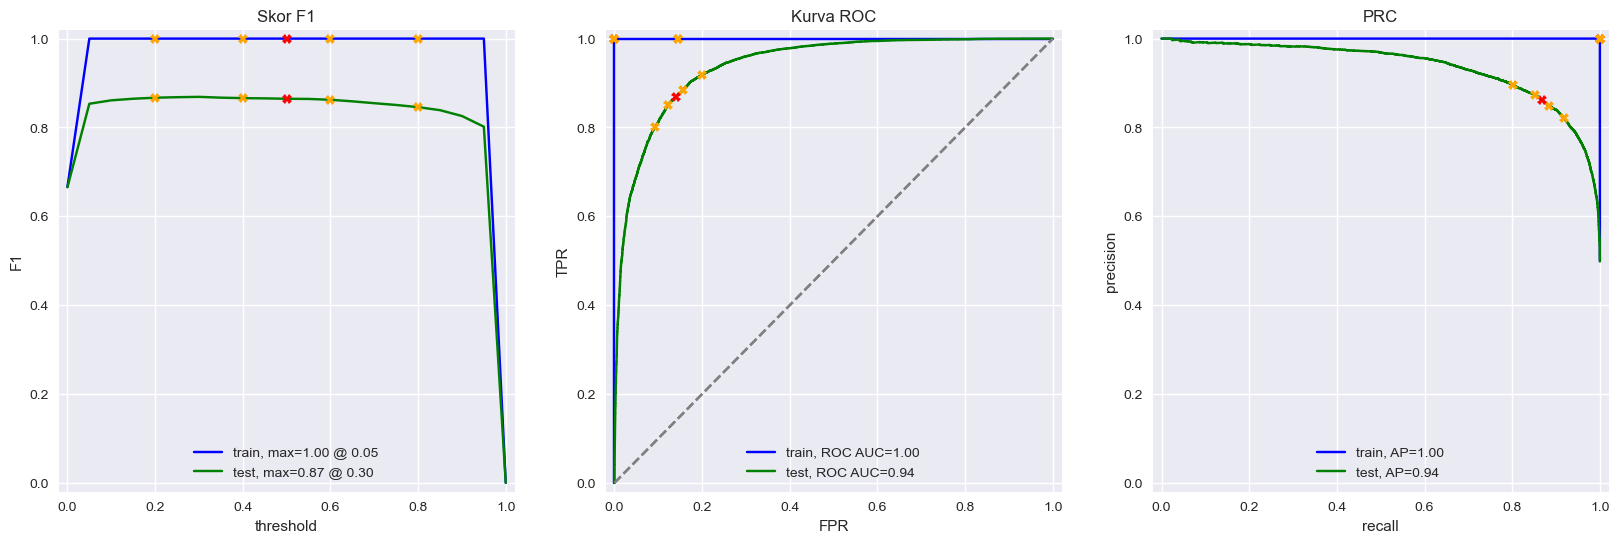

In [25]:
# evaluate the model based on the best parameter
model_fix = LGBMClassifier(learning_rate=0.5, n_estimators=100, num_leaves=100, objective='binary', random_state=42)
model_fix.fit(train_feature_3, train_target)
evaluate_model(model_fix, train_feature_3, train_target, test_feature_3, test_target)

### Model 9 - BERT

In [26]:
import torch
import transformers

In [27]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
sample_size=200
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # Text to ID tokens that have been padded together with an attention mask
    
    for text in tqdm(texts, disable=disable_progress_bar):
        ids = tokenizer.encode(text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Gunakan {device} perangkat.')
    
    # Get the embedding in batch

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)

        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [29]:
# Running BERT
train_features_9 = BERT_text_to_embeddings(df_reviews_train.iloc[:sample_size]['review_norm'], force_device='cpu')

  0%|          | 0/200 [00:00<?, ?it/s]

Gunakan cpu perangkat.


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15936\2300922897.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)


In [30]:
test_features_9 = BERT_text_to_embeddings(df_reviews_test[:sample_size]['review_norm'], force_device='cpu')

  0%|          | 0/200 [00:00<?, ?it/s]

Gunakan cpu perangkat.


  0%|          | 0/2 [00:00<?, ?it/s]

In [31]:
print("All Train Set:")
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)
print()
print("All Test Set:")
print(df_reviews_test['review_norm'].shape)
print(test_features_9.shape)
print(test_target.shape)

All Train Set:
(23796,)
(200, 768)
(23796,)

All Test Set:
(23535,)
(200, 768)
(23535,)


In [32]:
# save the train and test
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# load
with np.load('features_9.npz') as data:
    train_features_9 = data['train_features_9']
    test_features_9 = data['test_features_9']

In [33]:
# get the 200 data on target
sample_train_target = train_target.iloc[:sample_size]
sample_test_target = test_target.iloc[:sample_size]

In [34]:
# hyperparameter tuning
model_9 = LGBMClassifier()
param_grid = {
    'num_leaves':[20, 100],
    'n_estimators':[50, 100],
    'learning_rate':[0.1, 0.5],
    'objective':['binary'], 
    'random_state':[42]
}
grid_cv_9 = GridSearchCV(estimator=model_9, param_grid=param_grid, cv=5, n_jobs=-1)
grid_cv_9.fit(train_features_9, sample_train_target)
best_params_9 = grid_cv_9.best_params_

In [35]:
print("Best Score:", grid_cv_9.best_score_)
print("Best Parameter:", best_params_9)

Best Score: 0.805
Best Parameter: {'learning_rate': 0.5, 'n_estimators': 50, 'num_leaves': 20, 'objective': 'binary', 'random_state': 42}


          train  test
Accuracy    1.0  0.70
F1          1.0  0.65
APS         1.0  0.86
ROC AUC     1.0  0.85


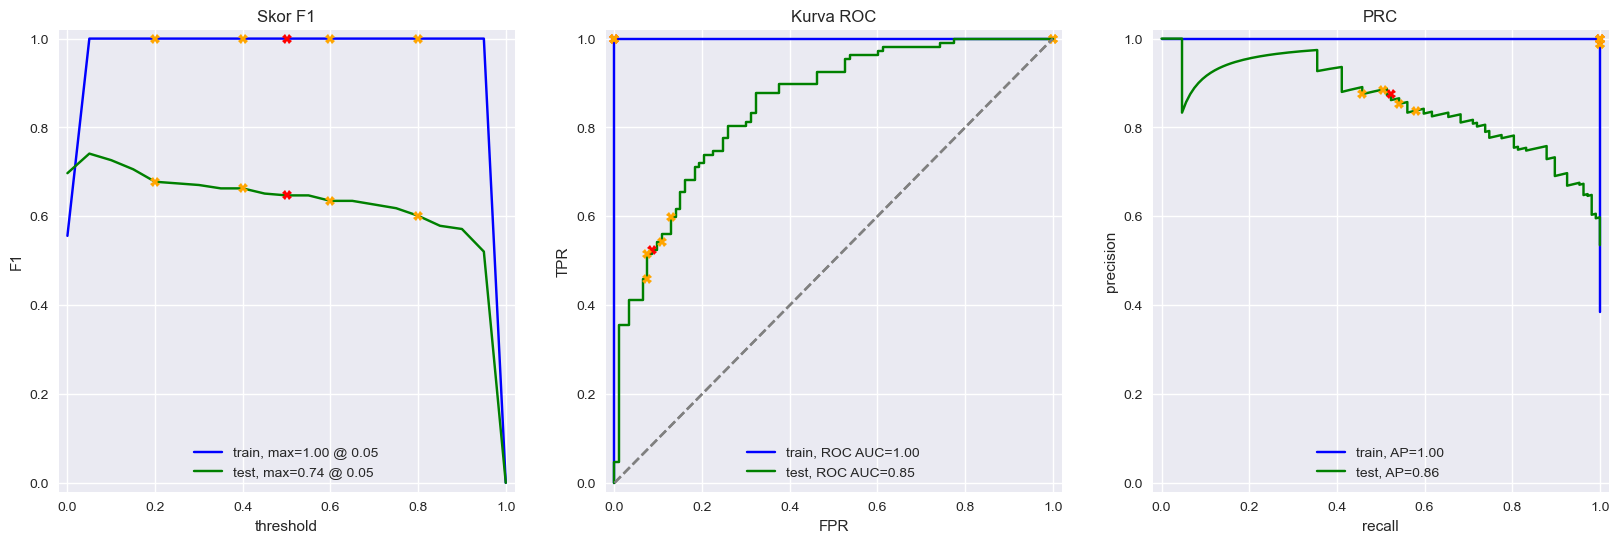

In [37]:
# train model and test it
model_fix_9 = LGBMClassifier(learning_rate=0.5, n_estimators=50, num_leaves=20, objective='binary', random_state=42)
model_fix_9.fit(train_features_9, sample_train_target)
evaluate_model(model_fix_9, train_features_9, sample_train_target, test_features_9, sample_test_target)

## My Reviews

In [38]:
# Making new data frame for reviews

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

prosessed = []
for i in range(my_reviews.shape[0]):
    prosessed.append(normalize(my_reviews.iloc[i]['review']))
    
my_reviews['review_norm'] = prosessed

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 2

In [39]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(count_tf_idf1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn t expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 3

In [40]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(count_tf_idf3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.14:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.10:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26:  i didn t expect the reboot to be so good writers really cared about the source material
0.51:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 4

In [41]:
texts = my_reviews['review_norm']

count_tf_idf4 = count_tf_idf3
my_reviews_pred_prob = model_fix.predict_proba(count_tf_idf4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.58:  i did not simply like it not my kind of movie
0.02:  well i was bored and felt asleep in the middle of the movie
0.55:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.01:  i didn t expect the reboot to be so good writers really cared about the source material
0.91:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.00:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
1.00:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 9

In [42]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)
my_reviews_pred_prob = model_fix_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.00:  i did not simply like it not my kind of movie
0.00:  well i was bored and felt asleep in the middle of the movie
0.00:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.00:  i didn t expect the reboot to be so good writers really cared about the source material
0.01:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.00:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.07:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Conclusion

**EDA Analysis:**
As seen, we have a growing number of reviews year by year, peaking in 2006. After 2006, the number of reviews we have decreases. This might be due to fewer people providing reviews as a result of film piracy.

**Module Analysis:**
The module that performs best in classifying between positive and negative classes is Logistic Regression. With an F1 Score of 0.95 on the training data and 0.88 on the testing data, as well as the same accuracy scores. For the LightGBM model, it has an accuracy score of 1.0 and an F1 Score of 0.86. While LightGBM appears to perform better, there is a concern about overfitting due to the exceptionally high training data performance.

In module 9, using BERT, we obtained very low scores, even below the specified threshold. This may have occurred due to a lack of sufficient training and testing data.

**Analysis for My Review Data:**
- Model 2 provides very low scores for the 4th and 5th reviews, even though both are positive reviews. On the other hand, it gives a very high score to the first review, which is also positive.
- Model 3 yields fairly good scores, especially for sentiment 7. However, there are instances where positive sentiments are mistakenly classified as negative by the model.
- Model 4 gives fairly good scores, especially with a 0.94 score for sentiment 7. However, there are still sentiments that are misclassified. For example, the first, second, and third sentiments.
- Model 9 provides very low scores, with all sentiments receiving a score of 0.